# Neural Network

Fully connected, feed-forward NN trained by backpropagation. Implemented from scratch.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Models

#### Helper functions
Computes activation for a vector of values

In [2]:
# Identity activation 
def identity(xVec):
    return xVec
def d_identity(xVec):
    return np.ones(np.shape(xVec))

# Sigmoid activation function
def sigmoid(xVec):
    denom = 1.0 + np.exp(-xVec)
    return np.divide(1, denom)

# Derivative of a sigmoid function
def d_sigmoid(xVec):
    return sigmoid(xVec) * (1.0 - sigmoid(xVec))

# Relu activation function
def relu(xVec):
    return np.maximum(0, xVec)

# Derivative of the relu activation function
def d_relu(xVec):
    return 1.0 * (xVec>0)

# Softmax and derivative
def softmax(xVec):
    expVec = np.exp(xVec)
    # If vector
    if np.shape(xVec)[1] == 1:
        return np.divide(expVec, np.sum(expVec))
    # If matrix
    else:
        transposedSum = np.sum(expVec, axis=1)
        transposedDivisor = np.divide(expVec.transpose(), transposedSum)
        return transposedDivisor.transpose()

def d_softmax(xVec):
    # NOTE: have not tested if it will work for matrices
    sf_xVec = softmax(xVec)
    return np.multiply(sf_xVec, np.subtract(1.0, sf_xVec))
    


## Store the above in dictionaries ##
activationFuncs = {}
activationFuncs['identity'] = identity
activationFuncs['d_identity'] = d_identity
activationFuncs['sigmoid'] = sigmoid
activationFuncs['d_sigmoid'] = d_sigmoid
activationFuncs['relu'] = relu
activationFuncs['d_relu'] = d_relu
activationFuncs['softmax'] = softmax
activationFuncs['d_softmax'] = d_softmax

Error / loss functions

In [3]:
def quadError(yTrue, yPred):
    return (0.5) * np.square( np.subtract(yPred, yTrue) )
def d_quadError(yTrue, yPred):
    return np.subtract(yPred, yTrue)

lossFuncs = {}
lossFuncs['quadratic'] = quadError
lossFuncs['d_quadratic'] = d_quadError

#### Define the sequential network class

In [23]:
class sequential_model:
    # Initialization
    def __init__(self, alpha=0.01, loss='quadratic'):
        # Learning hyper-parameters
        self.alpha = alpha
        self.lossFunc = lossFuncs[loss]
        self.d_lossFunc = lossFuncs['d_'+loss]
        
        # Parameter storage
        self.weights = []
        self.layerActivFuncs = [] # activation functions for each layer
        self.layerDerivActivFuncs = [] # derivative of activation functions for each layer
        self.layer_Primal_Out = []
        self.layer_Deriv_Out = []

        
    ## Methods to construct the NN ##
    # Initializing the input layer
    def input_layer(self, inputDim):
        self.layer_Primal_Out.append( np.empty(((inputDim+1),1)) )
        self.layer_Deriv_Out.append( np.empty(((inputDim+1),1)) )
        self.layerActivFuncs.append( activationFuncs['identity'] )
        self.layerDerivActivFuncs.append( activationFuncs['d_identity'] )
        
    def add_hidden(self, n_nodes, activation='relu'):
        # Compute the previous layer's index (i.e. current last layer)
        prev_l_idx = len(self.layer_Primal_Out) - 1
        # Previous layer's dimension
        prev_dim = len(self.layer_Primal_Out[prev_l_idx])
        
        # Initialize the weight matrix between current and past layer
        cur_w = np.random.normal(loc=0.0, scale=1.0, size=(prev_dim,n_nodes)) * 0.01
        self.weights.append( cur_w )
        
        # Current layer output and derivattives 
        self.layer_Primal_Out.append( np.empty(( (n_nodes+1),1 )) )
        self.layer_Deriv_Out.append( np.empty(( (n_nodes+1),1 )) )
        
        # Activation functions for current layer output
        self.layerActivFuncs.append( activationFuncs[activation] )
        self.layerDerivActivFuncs.append( activationFuncs['d_'+activation] )
    
    def output_layer(self, n_classes, activation='softmax'): 
        # Compute the previous layer's index (i.e. current last layer)
        prev_l_idx = len(self.layer_Primal_Out) - 1
        # Previous layer's dimension
        prev_dim = len(self.layer_Primal_Out[prev_l_idx])
        
        # Initialize the weight matrix between current and past layer
        cur_w = np.random.normal(loc=0.0, scale=1.0, size=(prev_dim,n_classes)) * 0.01
        self.weights.append( cur_w )
        
        # Current layer output and derivattives 
        self.layer_Primal_Out.append( np.empty(( n_classes , 1 )) )
        self.layer_Deriv_Out.append( np.empty(( n_classes , 1 )) )
        
        # Activation functions for current layer output
        self.layerActivFuncs.append( activationFuncs[activation] )
        self.layerDerivActivFuncs.append( activationFuncs['d_'+activation] )
    
    # Summarize #TODO: make the model summary cleaner
    def summarize(self):
        for i in range(len(self.weights)):
            print('Index %d:\t' % i, end='')
            print(np.shape(self.layer_Primal_Out[i]), end='')
            print(' --- ', end='')
            print(np.shape(self.weights[i]), end='')
            print(' --->')
        print("Output layer: \t", end='')
        print(np.shape(self.layer_Primal_Out[-1]))
    
    ## Training and predictions ##
    def train(self, train_X, train_y, epochs=10, validation=None, verbose=True, verboMod=1):
        # Initialize some variables
        N_examples = np.shape(train_X)[0]
        feat_dim = np.shape(train_X)[1]
        N_classes = np.shape(train_y)[1] # Assume one-hot
        
        # Store loss and accuracies
        trainingLoss = np.empty(epochs)
        validationLoss = np.empty(epochs)
        trainingAccuracy = np.empty(epochs)
        validationAccuracy = np.empty(epochs)
        
        ## Iterate through epochs ##
        for epoch_idx in range(0,epochs):
            
            if verbose and (epoch_idx % verboMod == 0):
                print("Epoch %d/%d\t| " % (epoch_idx+1, epochs), end='')
            
            # Iterate through each training example
            for ex_i in range(N_examples):
                # Shape feature vector and forward propogate
                cur_xVec = np.reshape(train_X[ex_i,:], (feat_dim, 1))
                self._forwardProp(cur_xVec)
                                
                # Shape label vector and back propogate 
                cur_yVec = np.reshape(train_y[ex_i], (N_classes, 1))
                curAvgLoss = self._backProp(cur_yVec)
                # Aggregate loss
                #totalTrainingLossThisEpoch += curAvgLoss
            
            # Compute and store the average loss for this epoch
            #trainingLoss[epoch_idx] = totalTrainingLossThisEpoch / N_examples
            
            # Compute training loss and accuracy this epoch
            trainingLoss[epoch_idx] = self.getLoss(train_X, train_y)
            trainingAccuracy[epoch_idx] = self.getAccuracy(train_X, train_y)
            
            # Compute validation loss, if available
            if validation != None:
                valid_X, valid_y = validation
                validationLoss[epoch_idx] = self.getLoss(valid_X, valid_y)
                validationAccuracy[epoch_idx] = self.getAccuracy(valid_X, valid_y)
            
            # Output
            if verbose and (epoch_idx % verboMod == 0):
                print("loss: %f\t| " % trainingLoss[epoch_idx], end='')
                print("acc: %f\t| " % trainingAccuracy[epoch_idx], end='')
                if validation != None:
                    print("val_loss: %f\t| " % validationLoss[epoch_idx], end='')
                    print("val_acc: %f\t| " % validationAccuracy[epoch_idx], end='')
                
                print()
        
        
        # Packge the metrics
        trainingMetrics = {}
        trainingMetrics['loss'] = trainingLoss
        trainingMetrics['acc'] = trainingAccuracy
        if validation != None:
            trainingMetrics['val_loss'] = validationLoss
            trainingMetrics['val_acc'] = validationAccuracy
                    
        return trainingMetrics
    
    ## Model prediction and evaluation functions ##
    # Predicts probability
    def predictProb(self, X):
        for l in range(0, len(self.weights)):
            # Activate current layer
            X_activated = self.layerActivFuncs[l](X)
            # Append bias
            X_withBias = np.hstack(( X_activated , np.ones((len(X_activated),1)) ))
            # Linear transform
            X = np.dot( X_withBias , self.weights[l] )
        
        # Activation of the last layer
        networkOut = self.layerActivFuncs[-1](X)
        return networkOut
    
    # Predicts the one-hot label
    #def predictLab(self, X):
    #    # Get the probability
    #    predProb = self.predictProb(X)
    #    # Get the most probable index as the label
    #    maxIdx = np.argmax(predProb, axis=1)
    #    oneHotOut = np.zeros(np.shape(predProb))
    
    # The loss
    def getLoss(self, X, true_y):
        # Predict y
        pred_y = self.predictProb(X)
        # Get a matrix of element-wise losses
        lossMat = self.lossFunc(true_y, pred_y)
        # Average losses
        return np.average(lossMat)
    
    # The accuracy
    def getAccuracy(self, X, true_y):
        # Predict y and get most likely predicted index
        pred_y = self.predictProb(X)
        pred_indeces = np.argmax(pred_y, axis=1)
        # Get most likley true indeces
        true_indeces = np.argmax(true_y, axis=1)
        # Get number of correct predictions
        return np.sum( (pred_indeces == true_indeces) ) / len(true_y)
        
    
    ## Internal training functions ##
    # feedforward computation (for single example)
    def _forwardProp(self, curInput_x):
        # Saving the inputs (output of first / input layer neurons)
        self.layer_Primal_Out[0] = np.vstack((curInput_x,1.0))
        
        # Compute the feedforward weighted computation to the next layer
        linTransOut = np.dot( self.weights[0].transpose(), self.layer_Primal_Out[0] )
        
        # Iterate through each subsequent layer
        for l in range(1, len(self.layer_Primal_Out)-1):
            # Apply activation for each neuron receiving input from previous layer
            activatedNeurons_noBias = self.layerActivFuncs[l](linTransOut)
            
            # Compute the derivative of the activation for later use
            d_activation_noBias = self.layerDerivActivFuncs[l](linTransOut)
            self.layer_Deriv_Out[l] = d_activation_noBias #NOTE: no bias added
            
            # Add bias to feedforward values and store
            self.layer_Primal_Out[l] = np.vstack((activatedNeurons_noBias, 1.0))
            
            # Compute feedforward matrix product for the next layer
            linTransOut = np.dot( self.weights[l].transpose(), self.layer_Primal_Out[l] )
        
        # Compute the output for the last layer
        self.layer_Primal_Out[-1] = self.layerActivFuncs[-1](linTransOut)
        self.layer_Deriv_Out[-1] = self.layerDerivActivFuncs[-1](linTransOut)
    
    
    # Backprop (for single examle)
    def _backProp(self, curInput_y):
        # Compute the loss and the derivative of the error at the last layer
        loss_vec = self.lossFunc(curInput_y, self.layer_Primal_Out[-1])
        d_error_vec = self.d_lossFunc(curInput_y, self.layer_Primal_Out[-1])
        
        # Compute the backprop error at the final layer
        backPropErrorVec = np.multiply( self.layer_Deriv_Out[-1] , d_error_vec )
        
        # Iterate backward through the layers (from last layer index to second layer index, comprehensively)
        for l in range( (len(self.weights)-1), 0, -1):
            # Save the old weights for backpropogation to earlier layer
            old_w = self.weights[l]
            
            # Compute the gradient for currents weights (i.e. between layer l and l+1)
            # ... using the back prop error from the l+1 layer
            gradient_w = np.dot( self.layer_Primal_Out[l], backPropErrorVec.transpose() )
            
            # Weight update for current layer
            delta_w = np.multiply( (-1.0 * self.alpha), gradient_w )
            self.weights[l] = np.add( self.weights[l], delta_w )
            
            # Back propogate the backpropr error to the current layer, getting rid of bias term
            weightedCurErrorVec = np.dot( old_w, backPropErrorVec )[:-1]
            # Update the backprop error to be used for the previous layer 
            backPropErrorVec = np.multiply( self.layer_Deriv_Out[l] , weightedCurErrorVec )
        
        ## Gradients and weights for the first layer (i.e. between 1st and 2nd layers) ## 
        gradient_w = np.dot( self.layer_Primal_Out[0], backPropErrorVec.transpose() )
        # Weight update for current layer
        delta_w = np.multiply( (-1.0 * self.alpha), gradient_w )
        self.weights[0] = np.add( self.weights[0], delta_w )
        
        
        # Compute and return the loss at the beginning of this back prop
        return np.average(loss_vec)

## Simulate 2D data

Simulating the "_NOT_" problem

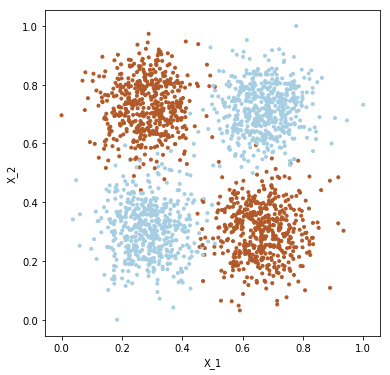

In [5]:
# Simulate data to test classifier
sim_size_per_class = 1000 # even number please

# Simulate two classes of gaussian data in the NOT configuration
sim_cov_mat = np.diag([0.8,0.8])
# First class
sim_c1_X1 = np.random.multivariate_normal([1, 5], sim_cov_mat, size=sim_size_per_class//2)
sim_c1_X2 = np.random.multivariate_normal([5, 1], sim_cov_mat, size=sim_size_per_class//2)
sim_c1_y = np.zeros((sim_size_per_class, 2))
sim_c1_y[:,0] = 1
sim_c1_y_int = np.ones(sim_size_per_class)*1 # for colour purposes
# Second class
sim_c2_X1 = np.random.multivariate_normal([1, 1], sim_cov_mat, size=sim_size_per_class//2)
sim_c2_X2 = np.random.multivariate_normal([5, 5], sim_cov_mat, size=sim_size_per_class//2)
sim_c2_y = np.zeros((sim_size_per_class, 2))
sim_c2_y[:,1] = 1
sim_c2_y_int = np.ones(sim_size_per_class) * -1 # for colour purposes

# Concatenate the classes
sim_X = np.vstack((sim_c1_X1, sim_c1_X2, sim_c2_X1, sim_c2_X2))
sim_y = np.vstack((sim_c1_y, sim_c2_y))
sim_y_int = np.concatenate((sim_c1_y_int, sim_c2_y_int))

# Shuffle data
from sklearn.utils import shuffle
sim_X, sim_y, sim_y_int = shuffle(sim_X, sim_y, sim_y_int, random_state=0)

# Scale data to have 0-1 range
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
sim_X = scaler.fit_transform(sim_X)

# divide into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sim_X, sim_y, test_size=0.2, random_state=42)


# Plot the data
import matplotlib
plt.figure(figsize=(6,6))
simColourmap = plt.get_cmap('Paired')
simCNorm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
# Plot the training set
plt.scatter(sim_X[:,0], sim_X[:,1], marker='.', cmap=simColourmap, norm=simCNorm, c=sim_y_int)
#plt.scatter(sim_c1_X[:,0], sim_c1_X[:,1], marker='o', cmap=simColourmap, norm=simCNorm, c=sim_predLabels[:sim_size_per_class])   
#plt.scatter(sim_c2_X[:,0], sim_c2_X[:,1], marker='x', cmap=simColourmap, norm=simCNorm, c=sim_predLabels[sim_size_per_class:])   
# Plotting the test set
#plt.scatter(sim_test_X[:,0], sim_test_X[:,1], marker='.', cmap=simColourmap, norm=simCNorm, c=sim_predTestLabels)   
# Labels
plt.xlabel("X_1")
plt.ylabel("X_2")

plt.show()

## Train network on data
** Model set-up**

In [56]:
model = sequential_model(alpha=0.08)

model.input_layer(2)
model.add_hidden(14, activation='sigmoid')
model.output_layer(2, activation='softmax')

model.summarize()

Index 0:	(3, 1) --- (3, 14) --->
Index 1:	(15, 1) --- (15, 2) --->
Output layer: 	(2, 1)


** Model training **

In [57]:
EPOCHS = 1000
trainingMetrics = model.train(X_train, y_train,
                              epochs=EPOCHS,
                              validation=(X_test, y_test),
                              verboMod=50
                             )

Epoch 1/1000	| loss: 0.125366	| acc: 0.493750	| val_loss: 0.124694	| val_acc: 0.525000	| 
Epoch 51/1000	| loss: 0.125515	| acc: 0.493750	| val_loss: 0.124689	| val_acc: 0.525000	| 
Epoch 101/1000	| loss: 0.125210	| acc: 0.340625	| val_loss: 0.124541	| val_acc: 0.380000	| 
Epoch 151/1000	| loss: 0.111167	| acc: 0.673125	| val_loss: 0.111709	| val_acc: 0.652500	| 
Epoch 201/1000	| loss: 0.031713	| acc: 0.921250	| val_loss: 0.033231	| val_acc: 0.917500	| 
Epoch 251/1000	| loss: 0.030077	| acc: 0.922500	| val_loss: 0.031233	| val_acc: 0.920000	| 
Epoch 301/1000	| loss: 0.027588	| acc: 0.927500	| val_loss: 0.028840	| val_acc: 0.922500	| 
Epoch 351/1000	| loss: 0.014388	| acc: 0.962500	| val_loss: 0.015063	| val_acc: 0.955000	| 
Epoch 401/1000	| loss: 0.009631	| acc: 0.974375	| val_loss: 0.010120	| val_acc: 0.972500	| 
Epoch 451/1000	| loss: 0.008964	| acc: 0.976250	| val_loss: 0.009286	| val_acc: 0.975000	| 
Epoch 501/1000	| loss: 0.008781	| acc: 0.978125	| val_loss: 0.009047	| val_acc: 0.9

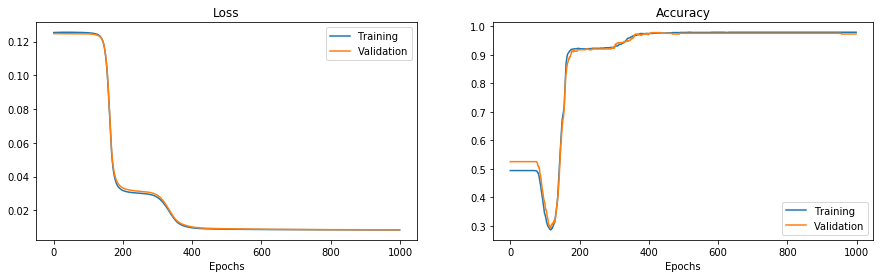

In [58]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(trainingMetrics['loss'])
plt.plot(trainingMetrics['val_loss'])
plt.xlabel("Epochs")
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(trainingMetrics['acc'])
plt.plot(trainingMetrics['val_acc'])
plt.xlabel("Epochs")
plt.title("Accuracy")
plt.legend(['Training', 'Validation'])
plt.show()

### Visualize the decision surface

(10000, 2)
(10000, 2)


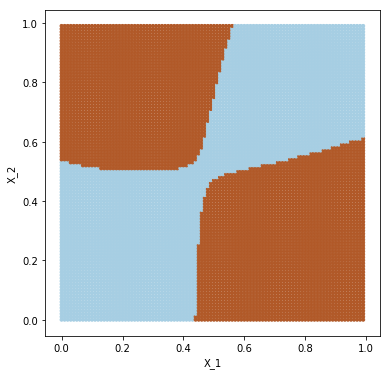

In [59]:
# The ranges of points to visualize
x1_ranges = np.arange(0.0, 1.0, 0.01)
x2_ranges = np.arange(0.0, 1.0, 0.01)

# Generate a datapoint for each of the above combinations
X_ranges = np.empty((len(x1_ranges)*len(x2_ranges), 2))
idx = 0
for x1 in x1_ranges:
    for x2 in x2_ranges:
        X_ranges[idx,0] = x1
        X_ranges[idx,1] = x2
        idx += 1
print(np.shape(X_ranges))


# Predict the datapoints
y_ranges = model.predictProb(X_ranges)
print(np.shape(y_ranges))

# Assign label to the output
ranges_predIndeces = np.argmax(y_ranges, axis=1)
# Shift labels to be +1 and -1
ranges_predIndeces = ranges_predIndeces * (-2)
ranges_predIndeces = ranges_predIndeces + 1


## Visualize ##
import matplotlib
plt.figure(figsize=(6,6))
simColourmap = plt.get_cmap('Paired')
simCNorm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
# Plot the training set
plt.scatter(X_ranges[:,0], X_ranges[:,1], marker='.', cmap=simColourmap, norm=simCNorm, c=ranges_predIndeces)
# Labels
plt.xlabel("X_1")
plt.ylabel("X_2")
plt.show()